# Country Codes in Datasets

We have multiple data sources which contains different sets of country codes.

In this notebook, we will analyse the country codes from different data sources and the ones that are supported by Tableau.

At the end of this notebook, we produce some CSV files.

## Table of Contents:

* [Country Code Analysis](#Country-Code-Analysis)
    * [Tableau Supported Map Data](#Tableau-Supported-Map-Data)
    * [World Bank Climate Data](#World-Bank-Climate-Data)
    * [Scrapped World Bank Temperature Data](#Scrapped-World-Bank-Temperature-Data)
    * [Intersecting the Country Codes](#Intersecting-the-Country-Codes)
* [Combining the Scrapped Data](#Combining-the-Scrapped-Data)
    * [Concatenating All Temperature Data](#Concatenating-All-Temperature-Data)*
    * [Concatenating Temperature Data of Available Country Codes](#Concatenating-Temperature-Data-of-Available-Country-Codes)*
    
\* produces CSV notebooks. All outputs are in `output\`

List of CSV produced in chronological order:

1. `temperature_all.csv`: All scrapped temperature data concatenated together
2. `temperature_filtered.csv`: Only scrapped temperature data with intersected country codes are concatenated

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles # need pip install matplotlib_venn
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import math
import os
import missingno as msno
from bs4 import BeautifulSoup
import requests
from tqdm.notebook import tqdm # (optional) to look cool when waiting for for loops 🙈 

import warnings
warnings.filterwarnings("ignore")

## Country Code Analysis

### Tableau Supported Map Data

[About Tableau Maps](https://www.tableau.com/mapdata?_ga=2.28389562.701025511.1644926306-701361297.1641624970#data)

In [2]:
url = "https://www.tableau.com/mapdata?_ga=2.28389562.701025511.1644926306-701361297.1641624970#data"

html_content = requests.get(url).text
soup = BeautifulSoup(html_content, "lxml")

In [3]:
main_content = soup.find("div", attrs={"id": "main_content"})
h5_contents = main_content.find_all("h5")

In [4]:
supported_country_names = {} 
supported_country_codes = []

for h5 in h5_contents:
    country_name_and_code = h5.contents[0]
    
    country_name = country_name_and_code[:-6]
    country_code = country_name_and_code[-4:-1]
    
    supported_country_names[country_code] = country_name
    supported_country_codes.append(country_code)

In [5]:
print(len(supported_country_codes), "Tableau supported country codes")
print(supported_country_codes)

250 Tableau supported country codes
['AFG', 'ALB', 'DZA', 'ASM', 'AND', 'AGO', 'AIA', 'ATA', 'ATG', 'ARG', 'ARM', 'ABW', 'AUS', 'AUT', 'AZE', 'BHR', 'BGD', 'BRB', 'BLR', 'BEL', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL', 'BES', 'BIH', 'BWA', 'BVT', 'BRA', 'IOT', 'VGB', 'BRN', 'BGR', 'BFA', 'BDI', 'KHM', 'CMR', 'CAN', 'CPV', 'CYM', 'CAF', 'TCD', 'CHL', 'CHN', 'CXR', 'CCK', 'COL', 'COM', 'COG', 'COK', 'CRI', 'HRV', 'CUB', 'CUW', 'CYP', 'CZE', 'CIV', 'COD', 'DNK', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'SLV', 'GNQ', 'ERI', 'EST', 'SWZ', 'ETH', 'FLK', 'FRO', 'FSM', 'FJI', 'FIN', 'FRA', 'GUF', 'PYF', 'ATF', 'GAB', 'GMB', 'GEO', 'DEU', 'GHA', 'GIB', 'GRC', 'GRL', 'GRD', 'GLP', 'GUM', 'GTM', 'GGY', 'GIN', 'GNB', 'GUY', 'HTI', 'HMD', 'HND', 'HKG', 'HUN', 'ISL', 'IND', 'IDN', 'IRN', 'IRQ', 'IRL', 'IMN', 'ISR', 'ITA', 'JAM', 'JPN', 'JEY', 'JOR', 'KAZ', 'KEN', 'KIR', 'KOS', 'KWT', 'KGZ', 'LAO', 'LVA', 'LBN', 'LSO', 'LBR', 'LBY', 'LIE', 'LTU', 'LUX', 'MAC', 'MDG', 'MWI', 'MYS', 'MDV', 'MLI', 'MLT', 'MHL', 'MTQ

### World Bank Climate Data

In [6]:
# worldbank imputed data
df_worldbank = pd.read_csv('output/worldbank_imputed.csv')

# worldbank country codebook
meta_country = pd.read_csv('dataset/worldbank/Metadata_Country_API_19_DS2_en_csv_v2_3159902.csv')

worldbank_country_codes = []
worldbank_country_names = df_worldbank['Country Name'].unique().tolist()

for country in worldbank_country_names:
    try:
        code = meta_country.loc[meta_country['TableName'] == country].iloc[0]['Country Code']
        worldbank_country_codes.append(code)
    except IndexError:
        print(country)

Cote d'Ivoire
Sao Tome and Principe
East Asia & Pacific (IDA & IBRD countries)
Europe & Central Asia (IDA & IBRD countries)
Latin America & the Caribbean (IDA & IBRD countries)
Middle East & North Africa (IDA & IBRD countries)
Sub-Saharan Africa (IDA & IBRD countries)


Cote d'Ivoire (CIV) and Sao Tome and Principe (STP) are spelled differently in Worldbank data and its codebook.

| Worldbank data        | Codebook              |
| --------------------- | --------------------- |
| Cote d'Ivoire         | Côte d'Ivoire         |
| Sao Tome and Principe | São Tomé and Principe |



In [7]:
display(meta_country.loc[meta_country['Country Code'] == 'CIV'])
display(meta_country.loc[meta_country['Country Code'] == 'STP'])

,Country Code,Region,IncomeGroup,SpecialNotes,TableName,Unnamed: 5
41,CIV,Sub-Saharan Africa,Lower middle income,NaN,Côte d'Ivoire,NaN


,Country Code,Region,IncomeGroup,SpecialNotes,TableName,Unnamed: 5
218,STP,Sub-Saharan Africa,Lower middle income,National account data were adjusted to reflect...,São Tomé and Principe,NaN


Therefore we add `CIV` and `STP` into the list.

In [8]:
worldbank_country_codes.append('CIV')
worldbank_country_codes.append('STP')

In [9]:
print(len(worldbank_country_codes), "country codes")
print(worldbank_country_codes)

250 country codes
['ABW', 'AFE', 'AFG', 'AFW', 'AGO', 'ALB', 'AND', 'ARB', 'ARE', 'ARG', 'ARM', 'ASM', 'ATG', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BHS', 'BIH', 'BLR', 'BLZ', 'BMU', 'BOL', 'BRA', 'BRB', 'BRN', 'BTN', 'BWA', 'CAF', 'CAN', 'CEB', 'CHE', 'CHL', 'CHN', 'CMR', 'COD', 'COG', 'COL', 'COM', 'CPV', 'CRI', 'CSS', 'CUB', 'CYM', 'CYP', 'CZE', 'DEU', 'DJI', 'DMA', 'DNK', 'DOM', 'DZA', 'EAP', 'EAR', 'EAS', 'ECA', 'ECS', 'ECU', 'EGY', 'EMU', 'ERI', 'ESP', 'EST', 'ETH', 'EUU', 'FCS', 'FIN', 'FJI', 'FRA', 'FRO', 'FSM', 'GAB', 'GBR', 'GEO', 'GHA', 'GIB', 'GIN', 'GMB', 'GNB', 'GNQ', 'GRC', 'GRD', 'GRL', 'GTM', 'GUM', 'GUY', 'HIC', 'HKG', 'HND', 'HPC', 'HRV', 'HTI', 'HUN', 'IBD', 'IBT', 'IDA', 'IDB', 'IDN', 'IDX', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KIR', 'KNA', 'KOR', 'KWT', 'LAC', 'LAO', 'LBN', 'LBR', 'LBY', 'LCA', 'LCN', 'LDC', 'LIC', 'LIE', 'LKA', 'LMC', 'LMY', 'LSO', 'LTE', 'LTU', 'LUX', '

### Scrapped World Bank Temperature Data 

In [10]:
path = "dataset/data_scraping/data/"
data_list = os.listdir(path)
data_list

['tas_timeseries_annual_cru_1901-2020_ABW.csv',
 'tas_timeseries_annual_cru_1901-2020_AFG.csv',
 'tas_timeseries_annual_cru_1901-2020_AGO.csv',
 'tas_timeseries_annual_cru_1901-2020_AIA.csv',
 'tas_timeseries_annual_cru_1901-2020_ALB.csv',
 'tas_timeseries_annual_cru_1901-2020_AND.csv',
 'tas_timeseries_annual_cru_1901-2020_ARE.csv',
 'tas_timeseries_annual_cru_1901-2020_ARG.csv',
 'tas_timeseries_annual_cru_1901-2020_ARM.csv',
 'tas_timeseries_annual_cru_1901-2020_ASM.csv',
 'tas_timeseries_annual_cru_1901-2020_ATG.csv',
 'tas_timeseries_annual_cru_1901-2020_AUS.csv',
 'tas_timeseries_annual_cru_1901-2020_AUT.csv',
 'tas_timeseries_annual_cru_1901-2020_AZE.csv',
 'tas_timeseries_annual_cru_1901-2020_BDI.csv',
 'tas_timeseries_annual_cru_1901-2020_BEL.csv',
 'tas_timeseries_annual_cru_1901-2020_BEN.csv',
 'tas_timeseries_annual_cru_1901-2020_BFA.csv',
 'tas_timeseries_annual_cru_1901-2020_BGD.csv',
 'tas_timeseries_annual_cru_1901-2020_BGR.csv',
 'tas_timeseries_annual_cru_1901-2020_BH

In [11]:
len(data_list)

228

In [12]:
scrapped_country_codes = [filename[-7:-4] for filename in data_list]
print(len(scrapped_country_codes), "country codes")
print(scrapped_country_codes)

228 country codes
['ABW', 'AFG', 'AGO', 'AIA', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ASM', 'ATG', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BHS', 'BIH', 'BLR', 'BLZ', 'BMU', 'BOL', 'BRA', 'BRB', 'BTN', 'BWA', 'CAF', 'CAN', 'CCK', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COK', 'COL', 'COM', 'CPV', 'CRI', 'CUB', 'CXR', 'CYM', 'CYP', 'CZE', 'DEU', 'DJI', 'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESH', 'ESP', 'EST', 'ETH', 'FIN', 'FJI', 'FLK', 'FRA', 'FRO', 'FSM', 'GAB', 'GBR', 'GEO', 'GHA', 'GIB', 'GIN', 'GLP', 'GMB', 'GNB', 'GNQ', 'GRC', 'GRD', 'GRL', 'GTM', 'GUF', 'GUM', 'GUY', 'HND', 'HRV', 'HTI', 'HUN', 'IDN', 'IND', 'IOT', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KIR', 'KNA', 'KOR', 'KWT', 'LAO', 'LBN', 'LBR', 'LBY', 'LCA', 'LIE', 'LKA', 'LSO', 'LTU', 'LUX', 'LVA', 'MAC', 'MAR', 'MCO', 'MDA', 'MDG', 'MDV', 'MEX', 'MHL', 'MKD', 'MLI', 'MLT', 'MMR', 'MNE', 'MNG', 'MNP', 'MOZ', 'MRT', 'MSR', '

### Intersecting the Country Codes

Now we have 3 lists of country codes:

* `supported_country_codes`: List of country codes supported by Tableau
* `worldbank_country_codes`: List of country codes from our imputed World Bank climate data
* `scrapped_country_codes`: List of country codes from our scrapped World Bank temperature data

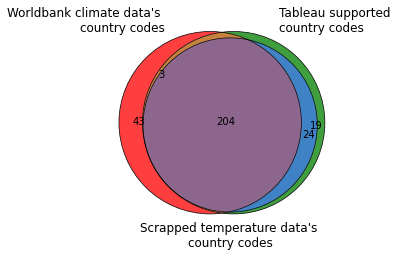

In [13]:
v = venn3([set(worldbank_country_codes), set(supported_country_codes), set(scrapped_country_codes)],
     set_labels = ("Worldbank climate data's \ncountry codes", 
                   "Tableau supported \ncountry codes",
                   "Scrapped temperature data's \ncountry codes"),
     alpha = 0.75)

# adds outter line
venn3_circles([set(worldbank_country_codes), set(supported_country_codes), set(scrapped_country_codes)], lw=0.7)

plt.show()

In [14]:
# intersecting the three lists
available_country_codes = list(set(worldbank_country_codes) & set(supported_country_codes) & set(scrapped_country_codes))
print(len(available_country_codes), "available country codes")
print(available_country_codes)

204 available country codes
['AUS', 'GAB', 'UKR', 'ISR', 'JAM', 'SGP', 'COM', 'RWA', 'KOR', 'PAN', 'BMU', 'ALB', 'DMA', 'GRD', 'CMR', 'GHA', 'OMN', 'MEX', 'SVN', 'PER', 'ERI', 'CHN', 'FRO', 'NZL', 'LAO', 'BWA', 'BFA', 'PYF', 'DEU', 'NOR', 'VCT', 'TKM', 'FIN', 'KEN', 'THA', 'MWI', 'NGA', 'ARE', 'AND', 'MRT', 'LSO', 'CAN', 'PRY', 'LKA', 'BHS', 'IRL', 'VNM', 'TON', 'MNG', 'IRQ', 'NIC', 'SVK', 'NCL', 'TCD', 'KHM', 'FJI', 'ARM', 'BLR', 'NLD', 'PSE', 'CYM', 'JPN', 'KGZ', 'LCA', 'LTU', 'ROU', 'LBY', 'BGD', 'SEN', 'CAF', 'SLB', 'SDN', 'TZA', 'GTM', 'URY', 'BOL', 'AFG', 'MYS', 'TUV', 'MAC', 'MNE', 'BRB', 'TLS', 'JOR', 'BDI', 'RUS', 'FRA', 'SYR', 'MOZ', 'CHE', 'TUR', 'UGA', 'ETH', 'KNA', 'TUN', 'DZA', 'LIE', 'PRK', 'PAK', 'SLE', 'WSM', 'PHL', 'ASM', 'SWZ', 'QAT', 'SLV', 'BRA', 'MMR', 'PNG', 'ISL', 'MHL', 'BHR', 'GMB', 'FSM', 'KIR', 'MUS', 'GBR', 'CYP', 'DOM', 'NAM', 'BTN', 'MAR', 'HTI', 'SRB', 'PRI', 'CUB', 'VEN', 'TCA', 'GUY', 'UZB', 'ABW', 'STP', 'MDA', 'MLT', 'IDN', 'YEM', 'TGO', 'CRI', 'VUT'

## Combining the Scrapped Data

Combine scrapped temperature data together (all or some)

Let's have a look again on our scrapped data.

In [15]:
temp_df = pd.read_csv(path + 'tas_timeseries_annual_cru_1901-2020_MYS.csv', skiprows=1)
temp_df

,Unnamed: 0,Malaysia,Johor,Kedah,Kelantan,Kuala Lumpur,Melaka,Negeri Sembilan,Pahang,Perak,Perlis,Pulau Pinang,Sabah,Sarawak,Selangor,Terengganu,Labuan
0,1901,25.13,26.12,26.45,24.59,25.05,26.35,25.81,25.12,25.01,27.49,26.95,24.91,24.97,25.85,25.34,27.12
1,1902,25.12,26.11,26.46,24.59,25.05,26.33,25.81,25.12,25.01,27.49,26.96,24.90,24.96,25.85,25.34,27.12
2,1903,25.07,26.11,26.38,24.54,25.05,26.33,25.81,25.12,24.98,27.39,26.90,24.72,24.96,25.85,25.31,27.05
3,1904,25.01,26.12,26.28,24.49,25.05,26.34,25.80,25.10,24.94,27.25,26.84,24.46,24.96,25.84,25.28,26.95
4,1905,25.10,26.14,26.73,24.79,25.05,26.36,25.81,25.15,25.15,27.78,27.14,24.61,24.97,25.85,25.46,27.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2016,26.30,27.56,27.65,25.90,26.43,27.76,27.19,26.48,26.33,28.56,28.19,25.94,26.04,27.21,26.66,28.18
116,2017,25.85,27.11,27.16,25.41,25.93,27.27,26.69,25.98,25.83,28.09,27.71,25.48,25.65,26.71,26.16,27.73
117,2018,25.89,27.15,27.18,25.42,25.95,27.32,26.73,26.02,25.84,28.09,27.73,25.57,25.68,26.74,26.20,27.80
118,2019,26.17,27.55,27.58,25.81,26.38,27.73,27.15,26.43,26.26,28.50,28.13,25.69,25.91,27.16,26.58,27.98


The normal csv file contains 120 rows (years, from 1901 to 2020). The columns should be the country itself, then the cities.

Let's double check if every csv file follows this format.

In [16]:
special_cases_df_list = []

# iterate the list of csv files name
for csv_file in data_list: 
    
    # skip first row as MOST files have unnecesary first row
    df = pd.read_csv(path + csv_file, skiprows=1)
    if len(df) != 120:
        print(f"{csv_file[-7:-4]}: {len(df)} rows")
        display(df.head(5))
        
        special_cases_df_list.append(csv_file)

special_cases_df_list

ESH: 119 rows


,1901,23.46
0,1902,23.45
1,1903,23.20
2,1904,23.11
3,1905,23.24
4,1906,23.25


FLK: 119 rows


,1901,6.38
0,1902,6.07
1,1903,6.10
2,1904,6.25
3,1905,5.74
4,1906,5.69


GLP: 119 rows


,1901,25.83
0,1902,25.49
1,1903,25.59
2,1904,25.18
3,1905,25.46
4,1906,25.32


GUF: 119 rows


,1901,26.11
0,1902,26.17
1,1903,26.15
2,1904,25.74
3,1905,25.95
4,1906,25.74


MTQ: 119 rows


,1901,25.23
0,1902,24.98
1,1903,25.05
2,1904,24.72
3,1905,24.93
4,1906,24.86


MYT: 119 rows


,1901,26.41
0,1902,26.66
1,1903,26.48
2,1904,26.43
3,1905,26.51
4,1906,26.46


REU: 119 rows


,1901,20.25
0,1902,20.38
1,1903,20.26
2,1904,20.26
3,1905,20.29
4,1906,20.30


['tas_timeseries_annual_cru_1901-2020_ESH.csv',
 'tas_timeseries_annual_cru_1901-2020_FLK.csv',
 'tas_timeseries_annual_cru_1901-2020_GLP.csv',
 'tas_timeseries_annual_cru_1901-2020_GUF.csv',
 'tas_timeseries_annual_cru_1901-2020_MTQ.csv',
 'tas_timeseries_annual_cru_1901-2020_MYT.csv',
 'tas_timeseries_annual_cru_1901-2020_REU.csv']

ESH, FLK, GLP, GUF, MTQ, MYT, REU are special cases. 

In [17]:
for csv_file in special_cases_df_list: 
    df = pd.read_csv(path + csv_file)
    print(f"{csv_file[-7:-4]}: {len(df)} rows")
    display(df.head())

ESH: 120 rows


,Variable:,tas
0,1901,23.46
1,1902,23.45
2,1903,23.20
3,1904,23.11
4,1905,23.24


FLK: 120 rows


,Variable:,tas
0,1901,6.38
1,1902,6.07
2,1903,6.10
3,1904,6.25
4,1905,5.74


GLP: 120 rows


,Variable:,tas
0,1901,25.83
1,1902,25.49
2,1903,25.59
3,1904,25.18
4,1905,25.46


GUF: 120 rows


,Variable:,tas
0,1901,26.11
1,1902,26.17
2,1903,26.15
3,1904,25.74
4,1905,25.95


MTQ: 120 rows


,Variable:,tas
0,1901,25.23
1,1902,24.98
2,1903,25.05
3,1904,24.72
4,1905,24.93


MYT: 120 rows


,Variable:,tas
0,1901,26.41
1,1902,26.66
2,1903,26.48
3,1904,26.43
4,1905,26.51


REU: 120 rows


,Variable:,tas
0,1901,20.25
1,1902,20.38
2,1903,20.26
3,1904,20.26
4,1905,20.29


Now they look correct.

### Concatenating All Temperature Data

Concatenating all scrapped temperature data regardless country codes.

First, we work on the files **without** special cases.

In [18]:
# data_list 'minus' special_cases_df_list
regular_df_list = [file for file in data_list if file not in special_cases_df_list]

# create a empty df with just year 1901-2020
df_world_temperature = pd.DataFrame({'Year': list(range(1901, 2021))})

# start merging files one by one
for file in tqdm(regular_df_list):
    
    # skips the first row when reading
    df_country = pd.read_csv(path + file, skiprows=1)
    df_country = df_country.iloc[:, :2] # slice the country column, ignoring states
    df_country.rename(columns = {'Unnamed: 0': 'Year'}, inplace=True)
    
    # merge them together
    df_world_temperature = pd.merge(df_world_temperature, df_country, on='Year')

  0%|          | 0/221 [00:00<?, ?it/s]

Next, let's on the special case files. 

The special case files does not provide the country name in the csv file. 

Fortunately, their names are available in the Tableau supported data. We may refer to the dictionary that we create earlier.

In [19]:
for file in special_cases_df_list:
    code = file[-7:-4]
    print(f"{code}: {supported_country_names.get(code)}")

ESH: Western Sahara
FLK: Falkland Islands (Islas Malvinas)
GLP: Guadeloupe
GUF: French Guiana
MTQ: Martinique
MYT: Mayotte
REU: Reunion


In [20]:
# start merging files one by one
for file in tqdm(special_cases_df_list):
    
    # get country code and name
    code = file[-7:-4]
    country_name = supported_country_names.get(code)
    
    # read csv file regularly
    df_country = pd.read_csv(path + file)
    df_country = df_country.iloc[:, :2] # slice the country column, ignoring states
    df_country.rename(columns = {'Variable:': 'Year', 'tas': f'{country_name}'}, inplace=True)
    
    # merge them together
    df_world_temperature = pd.merge(df_world_temperature, df_country, on='Year')

  0%|          | 0/7 [00:00<?, ?it/s]

In [21]:
df_world_temperature

,Year,Aruba,Afghanistan,Angola,Anguilla,Albania,Andorra,United Arab Emirates,Argentina,Armenia,...,South Africa,Zambia,Zimbabwe,Western Sahara,Falkland Islands (Islas Malvinas),Guadeloupe,French Guiana,Martinique,Mayotte,Reunion
0,1901,27.60,13.08,21.39,25.24,10.93,7.04,27.20,15.00,6.99,...,16.97,21.56,20.94,23.46,6.38,25.83,26.11,25.23,26.41,20.25
1,1902,27.17,13.27,21.43,24.84,10.87,7.36,26.73,14.63,6.09,...,16.84,21.81,21.33,23.45,6.07,25.49,26.17,24.98,26.66,20.38
2,1903,27.27,12.11,21.44,24.96,11.23,7.36,25.90,14.30,6.20,...,16.73,21.88,21.52,23.20,6.10,25.59,26.15,25.05,26.48,20.26
3,1904,27.00,12.56,21.35,24.43,11.26,7.91,26.21,14.49,5.79,...,16.77,21.28,20.47,23.11,6.25,25.18,25.74,24.72,26.43,20.26
4,1905,27.05,12.33,21.40,24.82,11.02,7.13,26.14,14.12,6.18,...,16.90,21.77,21.34,23.24,5.74,25.46,25.95,24.93,26.51,20.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2016,29.17,14.50,22.06,26.46,12.54,9.59,28.13,14.74,7.17,...,19.07,22.55,22.19,24.42,6.36,27.07,26.37,26.35,26.76,21.00
116,2017,28.68,14.12,21.92,26.38,12.36,9.52,28.09,15.30,7.38,...,18.61,22.21,21.65,24.67,6.30,26.91,26.15,26.19,27.07,21.40
117,2018,28.38,14.55,21.74,26.06,13.02,9.91,28.23,14.99,8.67,...,18.74,21.99,22.03,23.54,6.26,26.57,25.92,25.85,26.88,21.17
118,2019,28.75,13.86,21.88,26.48,12.94,9.81,28.10,14.97,7.95,...,19.36,22.44,22.30,24.15,6.12,26.92,26.21,26.15,27.22,21.55


In [22]:
len(data_list)

228

In [23]:
df_world_temperature.isna().sum().sort_values()

Year                  0
Nicaragua             0
Niue                  0
Netherlands           0
Norway                0
                   ... 
Guatemala             0
Guam                  0
Honduras              0
Reunion               0
Pitcairn Islands    120
Length: 229, dtype: int64

In [24]:
df_world_temperature.to_csv('output/temperature_all.csv', index=False)
print('Completed!')

Completed!


### Concatenating Temperature Data of Available Country Codes

Concatenating scrapped temperature data from the list of 'available' country codes.

One possible method is to filter out countries that are not in the list of available country codes.

Let's double check if all available country codes are in the combined scrapped data before we do it.

In [25]:
# a list of countries from all combined country codes
list_of_countries = df_world_temperature.columns.tolist()

Now we try to look for any missing countries in the codes.

In [26]:
missing = []

for code in available_country_codes:
    country_name = supported_country_names.get(code) # matching up with our data dictionary (from Tableau)
    if country_name not in list_of_countries:
        print(f"{code}: {country_name}")
        missing.append(code)
        
# printed results: country code and their country names from Tableau

KOR: South Korea
VCT: Saint Vincent and the Grenadines
BHS: The Bahamas
VNM: Viet Nam
FJI: Fiji Islands
PSE: Palestinian Territories
KGZ: Kyrgyzstan
LCA: Saint Lucia
TZA: Tanzania
MAC: Macau SAR
MNE: Montenegro
KNA: Saint Kitts and Nevis
PRK: North Korea
MMR: Myanmar
GMB: Gambia
SRB: Serbia
CZE: Czechia
CIV: Côte-d''Ivoire
MKD: North Macedonia
COG: Congo
COD: Democratic Republic of Congo


Turns out there is quite a long list of 'missing' countries

In [27]:
# country codes in combined scrapped df
for code in missing:
    if code not in scrapped_country_codes: # scrapped_country_codes is all
        print(code)

No results were printed. 

This indicates that all available country codes are still in combined scrapped data.

Just that the country names might spelled differently or called differently.

In [28]:
def check_scrapped_name(code):

    # no need to worry for special case here
    df = pd.read_csv(f"{path}tas_timeseries_annual_cru_1901-2020_{code}.csv", skiprows=1) 
    print(f"{code}: {df.columns[1]}")
    
for code in missing:
    check_scrapped_name(code)
    
# printed results: country code and their country names from Scrapped Data

KOR: Korea, Republic of
VCT: St. Vincent and the Grenadines
BHS: Bahamas, The
VNM: Vietnam
FJI: Fiji
PSE: West Bank and Gaza
KGZ: Kyrgyz Republic
LCA: St. Lucia
TZA: Tanzania, United Republic of
MAC: Macao SAR, China
MNE: Republic of Montenegro
KNA: St. Kitts and Nevis
PRK: Korea, Democratic People's Republic of
MMR: Myanmar (Burma)
GMB: Gambia, The
SRB: Republic of Serbia
CZE: Czech Republic
CIV: Cote d'Ivoire
MKD: Macedonia
COG: Congo (Republic of the)
COD: Congo (Democratic Republic of the)


Now we may proceed to filter out the country with our list of misspelled countries.

**But**, it can still be very troublesome.

Therefore we can append the available country codes like how we did it in [Concatenating All Temperature Data](#Concatenating-All-Temperature-Data)

Let's do a quick check on the special cases countries from the last time (countries with strange CSV format)

In [29]:
special_cases_df_list

['tas_timeseries_annual_cru_1901-2020_ESH.csv',
 'tas_timeseries_annual_cru_1901-2020_FLK.csv',
 'tas_timeseries_annual_cru_1901-2020_GLP.csv',
 'tas_timeseries_annual_cru_1901-2020_GUF.csv',
 'tas_timeseries_annual_cru_1901-2020_MTQ.csv',
 'tas_timeseries_annual_cru_1901-2020_MYT.csv',
 'tas_timeseries_annual_cru_1901-2020_REU.csv']

In [30]:
for file in special_cases_df_list:
    code = file[-7:-4]
    if code in available_country_codes: # if the special case countries is in 
        print(code)

Nothing prints out!

We can safely iterate the list of available country codes and append them one by one.

In [31]:
# create a empty df with just year 1901-2020
df_filtered_temperature = pd.DataFrame({'Year': list(range(1901, 2021))})

# start merging files one by one
for code in tqdm(available_country_codes):
    
    # skips the first row when reading
    df_country = pd.read_csv(f"{path}tas_timeseries_annual_cru_1901-2020_{code}.csv", skiprows=1)
    df_country = df_country.iloc[:, :2] # slice the country column, ignoring states
    df_country.rename(columns = {'Unnamed: 0': 'Year'}, inplace=True)
    
    # merge them together
    df_filtered_temperature = pd.merge(df_filtered_temperature, df_country, on='Year')

  0%|          | 0/204 [00:00<?, ?it/s]

In [32]:
len(available_country_codes)

204

In [33]:
df_filtered_temperature

,Year,Australia,Gabon,Ukraine,Israel,Jamaica,Singapore,Comoros,Rwanda,"Korea, Republic of",...,Maldives,Latvia,Zambia,United States,Suriname,Spain,Virgin Islands,Azerbaijan,Nauru,Angola
0,1901,21.63,24.67,8.63,19.30,23.87,26.59,23.97,19.00,9.69,...,27.63,5.99,21.56,8.58,26.20,12.17,25.40,12.64,27.73,21.39
1,1902,21.63,24.87,7.06,18.83,24.15,26.53,24.20,19.14,10.22,...,27.63,3.94,21.81,8.40,26.21,12.39,24.98,11.89,27.73,21.43
2,1903,21.27,25.01,8.74,17.75,24.09,26.55,24.06,18.99,10.17,...,27.63,6.47,21.88,7.95,26.19,12.46,25.06,11.90,27.73,21.44
3,1904,21.18,24.70,7.51,18.40,24.04,26.56,23.90,18.70,10.05,...,27.63,4.94,21.28,8.13,25.80,12.85,24.56,11.45,27.73,21.35
4,1905,21.28,25.10,8.29,18.68,24.31,26.60,24.11,18.63,10.24,...,27.63,5.76,21.77,8.40,26.02,12.19,24.91,11.78,27.73,21.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2016,22.50,25.82,9.76,21.20,25.32,28.09,24.60,19.52,12.09,...,27.80,7.11,22.55,10.68,26.41,14.34,26.69,12.95,27.86,22.06
116,2017,22.57,25.50,9.83,20.81,25.20,27.70,24.83,19.68,11.74,...,27.75,6.88,22.21,10.24,26.26,14.59,26.56,13.17,27.84,21.92
117,2018,22.58,25.70,9.87,21.51,25.19,27.74,24.66,19.27,11.62,...,27.73,7.56,21.99,9.89,26.04,14.19,26.23,14.16,27.83,21.74
118,2019,22.88,25.57,10.68,20.93,25.38,28.12,24.99,19.49,12.20,...,27.78,7.98,22.44,9.74,26.35,14.38,26.66,13.72,28.06,21.88


In [34]:
df_filtered_temperature.isna().sum().sort_values()

Year                            0
Uzbekistan                      0
Aruba                           0
Sao Tome and Principe           0
Moldova                         0
                               ..
Solomon Islands                 0
Sudan                           0
Tanzania, United Republic of    0
Kyrgyz Republic                 0
Angola                          0
Length: 205, dtype: int64

In [35]:
df_filtered_temperature.to_csv('output/temperature_filtered.csv', index=False)
print('Completed!')

Completed!
